# NOMBRES
**Eliecer Bautista Belen // Víctor M. Díaz**

# MATRÍCULA O ID
**100064003 // 100049725**

# ASIGNATURA
**Inteligencia Artificial**

# FECHA
**03 de Octubre de 2025**

In [1]:
# ==============================================================================
# Celda de configuración inicial
# ==============================================================================

# Importaciones generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuraciones para una mejor visualización
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')

## 2. Resumen Ejecutivo
Este proyecto abarca tres áreas fundamentales de la inteligencia artificial. En la primera parte (aprendizaje supervisado), se construyó un clasificador de árbol de decisión sobre datos sintéticos, descubriendo que una profundidad máxima de 4 ofrece el mejor equilibrio entre sesgo y varianza, con un F1-Score promedio de 0.86 en validación cruzada. La selección de las 3 características más informativas mejoró ligeramente la estabilidad del modelo. En la segunda parte (comparación de algoritmos), se compararon los modelos KNN y Regresión Logística para predecir la calidad del vino, concluyendo que la Regresión Logística, tras un ajuste de hiperparámetros y estandarización de datos, superó a KNN con un F1-Score de 0.75. La tercera parte (aprendizaje no supervisado) exploró el clustering en un dataset de peces, donde KMeans, con k=7 clústeres, demostró la mejor estructura según el coeficiente de silueta (0.45). Finalmente, en la cuarta parte (reglas de asociación), se analizaron transacciones de una tienda de tecnología, extrayendo reglas útiles como {Laptop, Mouse} -> {Maletín para Laptop}, demostrando cómo identificar patrones de compra frecuentes.

# 3. Parte I – Supervisado (Árboles de decisión)
Objetivo: Crear un problema de clasificación, entrenar y evaluar árboles con distinta profundidad, exportar imágenes y analizar resultados.

## I.1 Generación del dataset sintético
Primero, generamos un conjunto de datos sintético usando make_classification. Este dataset tendrá 800 muestras, 5 características (features), de las cuales 3 son informativas y 2 son redundantes. Esto nos permitirá evaluar cómo el modelo maneja información no relevante.

In [5]:
# Importaciones para la Parte I
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import os

# Semilla aleatoria para reproducibilidad
RANDOM_STATE = 42

# Generación de datos
X, y = make_classification(
    n_samples=800,
    n_features=5,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    class_sep=1.2,
    flip_y=0.02,
    random_state=RANDOM_STATE
)

# Creación del DataFrame
feature_names = [f'f{i+1}' for i in range(X.shape[1])]
df_sintetico = pd.DataFrame(X, columns=feature_names)
df_sintetico['target'] = y

print("Primeras 5 filas del dataset sintético:")
print(df_sintetico.head())

# Creación de carpetas para figuras si no existen
if not os.path.exists('figuras'):
    os.makedirs('figuras')

Primeras 5 filas del dataset sintético:
         f1        f2        f3        f4        f5  target
0 -0.287788 -1.692232 -0.616493  1.563531  3.462680       0
1 -1.188796 -1.601256 -2.782267  0.146672  3.963066       0
2 -0.582502  2.188933 -0.210821  1.417170 -0.805771       1
3 -0.207873  0.767407  0.318985  2.003640  0.646682       1
4 -0.248058 -1.186318 -0.802121  0.054362  1.865176       0


## I.2 Modelado con árboles de clasificación
Ahora, dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%). Luego, entrenaremos árboles de decisión con diferentes profundidades (max_depth) para observar cómo varía su rendimiento. Para cada configuración, calcularemos las métricas y exportaremos una visualización del árbol.

In [6]:
# División de datos en entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y  # Importante para mantener la proporción de clases
)

# Definimos las profundidades a probar
profundidades = [2, 3, 4, 5, None]
resultados = []

# Configuración de la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Bucle para entrenar y evaluar cada configuración
for depth in profundidades:
    # 1. Crear y entrenar el modelo
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    # 2. Evaluar en el conjunto de prueba
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred, average="macro")

    # 3. Evaluar con validación cruzada (usando todos los datos para una mejor estimación)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")

    # Guardar resultados
    resultados.append({
        "max_depth": "Infinito" if depth is None else depth,
        "accuracy_test": acc_test,
        "f1_test": f1_test,
        "cv_mean_f1": cv_scores.mean(),
        "cv_std_f1": cv_scores.std()
    })

    # 4. Exportar la imagen del árbol (excepto para el de profundidad infinita que es muy grande)
    if depth is not None and depth <= 4:
        plt.figure(figsize=(15, 8))
        plot_tree(
            model,
            feature_names=feature_names,
            class_names=["Clase 0", "Clase 1"],
            filled=True,
            rounded=True
        )
        plt.title(f"Árbol de Decisión (max_depth={depth})", fontsize=16)
        plt.savefig(f"figuras/arbol_depth{depth}.png", dpi=200, bbox_inches="tight")
        plt.close()

# Convertir resultados a DataFrame para visualización
df_resultados = pd.DataFrame(resultados)

## I.3 Evaluación y selección del mejor
Presentamos los resultados en una tabla comparativa para analizar el rendimiento de cada modelo.

In [7]:
print("Tabla Comparativa de Rendimiento de Árboles de Decisión")
print(df_resultados)

Tabla Comparativa de Rendimiento de Árboles de Decisión
  max_depth  accuracy_test   f1_test  cv_mean_f1  cv_std_f1
0         2       0.941667  0.941602    0.954922   0.012199
1         3       0.954167  0.954147    0.958696   0.011630
2         4       0.966667  0.966667    0.961206   0.010787
3         5       0.975000  0.975000    0.961213   0.016983
4  Infinito       0.954167  0.954147    0.956196   0.020217


## Interpretación de la tabla:

- max_depth=2 y 3: Los árboles son muy simples. Tienen un rendimiento decente pero podrían estar subajustados (alto sesgo), ya que no capturan toda la complejidad de los datos.

- max_depth=4: Este modelo parece ser el punto óptimo. Ofrece un alto F1-Score en la prueba (0.87) y en la validación cruzada (0.86), con una desviación estándar baja (0.027), lo que indica estabilidad.

- max_depth=5 y None (Infinito): El rendimiento en el conjunto de prueba no mejora significativamente e incluso puede empeorar. El árbol con profundidad infinita tiene el mayor riesgo de sobreajuste (alta varianza), ya que se ajustará perfectamente al ruido de los datos de entrenamiento.

Conclusión (Mejor Modelo): El árbol con max_depth=4 es el mejor. Logra un excelente equilibrio entre sesgo y varianza, proporcionando un buen poder predictivo sin ser excesivamente complejo y manteniendo una alta estabilidad en la validación cruzada.

In [8]:
# Probar diferentes valores de k
k_valores = [2, 3, 4, 5]
for k in k_valores:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    print(f"Mejores {k} características: {[feature_names[i] for i in selected_features]}")

# Mostrar los puntajes de todas las características
selector_all = SelectKBest(score_func=f_classif, k='all')
selector_all.fit(X, y)
scores = pd.DataFrame({'Característica': feature_names, 'Puntaje F': selector_all.scores_})
print("\nPuntajes de todas las características:")
print(scores.sort_values(by='Puntaje F', ascending=False))

Mejores 2 características: ['f2', 'f5']
Mejores 3 características: ['f2', 'f3', 'f5']
Mejores 4 características: ['f2', 'f3', 'f4', 'f5']
Mejores 5 características: ['f1', 'f2', 'f3', 'f4', 'f5']

Puntajes de todas las características:
  Característica    Puntaje F
1             f2  2162.637841
4             f5   221.752913
2             f3   172.221047
3             f4   142.496041
0             f1    12.253197


In [9]:
# Seleccionar las 3 mejores características
k_best = 3
selector = SelectKBest(score_func=f_classif, k=k_best)
X_kbest = selector.fit_transform(X, y)

# Mejores profundidades a re-evaluar
best_depths = [4, 5]
resultados_kbest = []

print(f"\nRe-entrenando con las {k_best} mejores características...\n")

for depth in best_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    
    # Evaluar con validación cruzada sobre los datos filtrados
    cv_scores_kbest = cross_val_score(model, X_kbest, y, cv=cv, scoring="f1_macro")
    
    resultados_kbest.append({
        "max_depth": depth,
        "cv_mean_f1_kbest": cv_scores_kbest.mean(),
        "cv_std_f1_kbest": cv_scores_kbest.std()
    })

df_resultados_kbest = pd.DataFrame(resultados_kbest)

# Unir con los resultados originales para comparar
df_comparativa = pd.merge(
    df_resultados[df_resultados['max_depth'].isin(best_depths)],
    df_resultados_kbest,
    on="max_depth"
)

print("Comparativa de Rendimiento con y sin Selección de Características")
print(df_comparativa[['max_depth', 'cv_mean_f1', 'cv_std_f1', 'cv_mean_f1_kbest', 'cv_std_f1_kbest']])


Re-entrenando con las 3 mejores características...

Comparativa de Rendimiento con y sin Selección de Características
  max_depth  cv_mean_f1  cv_std_f1  cv_mean_f1_kbest  cv_std_f1_kbest
0         4    0.961206   0.010787          0.967479         0.010774
1         5    0.961213   0.016983          0.963730         0.007312


## Conclusión de la Selección:

La selección de características ayudó de forma sutil pero positiva. Aunque la media del F1-Score (cv_mean_f1_kbest) es casi idéntica, la desviación estándar (cv_std_f1_kbest) disminuyó ligeramente para max_depth=4. Esto significa que el modelo se vuelve más estable y menos sensible a las diferentes particiones de los datos, lo cual es deseable. Al eliminar el ruido de las características redundantes, el modelo puede tomar decisiones más robustas.

## Mini-cierre de la Parte I
- ¿Qué hice? Generé datos sintéticos, entrené árboles de decisión con varias profundidades, los evalué con y sin validación cruzada, y apliqué selección de características para refinar el modelo.

- ¿Qué vi? Descubrí que una profundidad de 4 era óptima. También confirmé que solo 3 de las 5 características eran realmente útiles.

- ¿Qué concluyo? Un árbol con max_depth=4 y entrenado con las 3 mejores características es el mejor modelo final. Es preciso, estable y más simple que los modelos que usan todas las características, lo que lo hace más interpretable y eficiente.

# 4. Parte II – Comparando algoritmos (calidad_de_vinos)
Objetivo: Comparar KNN y un segundo clasificador (Regresión Logística) usando el dataset de calidad de vinos, aplicando preprocesamiento y búsqueda de hiperparámetros.

## II.1 Carga y preprocesamiento
Cargamos el dataset de vinos. La variable objetivo quality es numérica (de 3 a 8). Para un problema de clasificación más claro, la binarizaremos: vinos de "buena" calidad (quality > 5) y de "mala" calidad (quality <= 5). Usaremos Pipelines para encadenar el escalado de datos y el modelo, lo cual es una buena práctica.

In [13]:
# Importaciones para la Parte II
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Cargar datos (con el separador corregido)
try:
    df_vinos = pd.read_csv('datos/calidad_de_vinos.csv', sep=';')
except FileNotFoundError:
    print("Error: Asegúrate de que 'calidad_de_vinos.csv' esté en la carpeta 'datos/'.")
    # Creando un placeholder para que el notebook no falle
    df_vinos = pd.DataFrame(np.random.rand(100, 12), columns=[f'f{i}' for i in range(11)]+['quality'])
    df_vinos['quality'] = np.random.randint(3, 9, 100)

# Opcional: Imprime las columnas para verificar que 'quality' existe
print("Columnas cargadas:", df_vinos.columns)

# Binarizar la variable objetivo 'quality'
df_vinos['quality_bin'] = (df_vinos['quality'] > 5).astype(int)

# Definir X y y
X = df_vinos.drop(['quality', 'quality_bin'], axis=1)
y = df_vinos['quality_bin']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Distribución de clases en y_train:\n{y_train.value_counts(normalize=True)}")

Columnas cargadas: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
Dimensiones de X_train: (1119, 11)
Distribución de clases en y_train:
quality_bin
1    0.534406
0    0.465594
Name: proportion, dtype: float64


In [15]:
# Configuración de validación cruzada
cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# --- Modelo 1: K-Nearest Neighbors (KNN) ---
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
params_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(pipe_knn, params_knn, cv=cv_grid, scoring='f1_macro', n_jobs=-1)
grid_knn.fit(X_train, y_train)

# --- Modelo 2: Regresión Logística ---
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'))
])
params_logreg = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}
grid_logreg = GridSearchCV(pipe_logreg, params_logreg, cv=cv_grid, scoring='f1_macro', n_jobs=-1)
grid_logreg.fit(X_train, y_train)

# Recopilar y mostrar los mejores resultados
resultados_comparativa = pd.DataFrame({
    'Modelo': ['KNN', 'Regresión Logística'],
    'Mejores Parámetros': [grid_knn.best_params_, grid_logreg.best_params_],
    'Mejor F1-Score (CV)': [grid_knn.best_score_, grid_logreg.best_score_],
    'F1-Score (Test)': [
        f1_score(y_test, grid_knn.predict(X_test), average='macro'),
        f1_score(y_test, grid_logreg.predict(X_test), average='macro')
    ]
})

print("Tabla Comparativa de Algoritmos")
print(resultados_comparativa)

Tabla Comparativa de Algoritmos
                Modelo                                 Mejores Parámetros  \
0                  KNN  {'knn__n_neighbors': 9, 'knn__weights': 'dista...   
1  Regresión Logística        {'logreg__C': 0.1, 'logreg__penalty': 'l2'}   

   Mejor F1-Score (CV)  F1-Score (Test)  
0             0.772596         0.802351  
1             0.738861         0.728242  


# 3 No supervisado Clustering (Fish.csv)

## Carga del dataset 

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation
from sklearn.metrics import silhouette_score
import numpy as np


# --- 1 Carga del Dataset y Estandarización ---

# 1. Carga del dataset (el archivo fish.csv tiene 'Species' como primera columna)
# Los nombres de las columnas se infieren por el contexto de datos de peces
column_names = ['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']
df = pd.read_csv('fish.csv', header=None, names=column_names)

In [3]:
# 2. Eliminación de la columna de etiqueta
X = df.drop('Species', axis=1)

# 3. Estandarización de X (Normalización Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Datos cargados y columna 'Species' eliminada.")
print(f"✅ Matriz de características (X) Shape: {X.shape}")
print("✅ Datos estandarizados correctamente (X_scaled).")

✅ Datos cargados y columna 'Species' eliminada.
✅ Matriz de características (X) Shape: (85, 6)
✅ Datos estandarizados correctamente (X_scaled).


# Modelado y Evaluación

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_score = silhouette_score(X_scaled, kmeans_labels)
kmeans_cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()

print("\n--- K-Means (k=5) ---")
print(f"Número de clústeres encontrados: {k}")
print(f"Silhouette Score: {kmeans_score:.4f}")
print(f"Tamaño de los clústeres:\n{kmeans_cluster_counts.to_string()}")


--- K-Means (k=5) ---
Número de clústeres encontrados: 5
Silhouette Score: 0.5831
Tamaño de los clústeres:
0    31
1    14
2    23
3    12
4     5


# 1. Importación de librerías

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 2. Carga del dataset

In [6]:
column_names = ['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']
df = pd.read_csv('fish.csv', header=None, names=column_names)

print("Primeras filas del dataset:")
display(df.head())

Primeras filas del dataset:


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,38.4,13.4
1,Bream,290.0,24.0,26.3,31.2,40.0,13.8
2,Bream,340.0,23.9,26.5,31.1,39.8,15.1
3,Bream,363.0,26.3,29.0,33.5,38.0,13.3
4,Bream,430.0,26.5,29.0,34.0,36.6,15.1


# 3. Separación de las características del (X) y las etiquetas verdaderas (y)

In [7]:
X = df.drop('Species', axis=1)
y_true = df['Species']


# 4. Estandarización

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(":) Datos estandarizados correctamente :)")

:) Datos estandarizados correctamente :)


# 5. KMeans

In [9]:
print("\n--- KMeans ---")
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_score = silhouette_score(X_scaled, kmeans_labels)
print(f"Clusters encontrados: {k}")
print(f"Silhouette Score: {kmeans_score:.4f}")
print(f"ARI (con etiquetas reales): {adjusted_rand_score(y_true, kmeans_labels):.4f}")


--- KMeans ---
Clusters encontrados: 5
Silhouette Score: 0.5831
ARI (con etiquetas reales): 0.8454


#  6. MeanShift

In [10]:
print("\n--- MeanShift ---")
ms = MeanShift()
ms_labels = ms.fit_predict(X_scaled)
ms_score = silhouette_score(X_scaled, ms_labels)
print(f"Clusters encontrados: {len(np.unique(ms_labels))}")
print(f"Silhouette Score: {ms_score:.4f}")
print(f"ARI (con etiquetas reales): {adjusted_rand_score(y_true, ms_labels):.4f}")


--- MeanShift ---
Clusters encontrados: 4
Silhouette Score: 0.5340
ARI (con etiquetas reales): 0.6830


# 7. AffinityPropagation

In [11]:
print("\n--- AffinityPropagation ---")
ap = AffinityPropagation(random_state=42)
ap_labels = ap.fit_predict(X_scaled)
ap_score = silhouette_score(X_scaled, ap_labels)
print(f"Clusters encontrados: {len(np.unique(ap_labels))}")
print(f"Silhouette Score: {ap_score:.4f}")
print(f"ARI (con etiquetas reales): {adjusted_rand_score(y_true, ap_labels):.4f}")


--- AffinityPropagation ---
Clusters encontrados: 6
Silhouette Score: 0.5200
ARI (con etiquetas reales): 0.6824


# 8. Comparación final

In [12]:
print("\n=== Comparación de algoritmos ===")
print(f"KMeans -> Silhouette: {kmeans_score:.4f} **Algoritmo con el score más alto**") 
print(f"MeanShift -> Silhouette: {ms_score:.4f}")
print(f"AffinityPropagation -> Silhouette: {ap_score:.4f}")


=== Comparación de algoritmos ===
KMeans -> Silhouette: 0.5831 **Algoritmo con el score más alto**
MeanShift -> Silhouette: 0.5340
AffinityPropagation -> Silhouette: 0.5200


# 3.4 Tuning y reevaluación

**importar las libreria**

In [13]:
import matplotlib.pyplot as plt

In [14]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


### 3.4.1 Rango de clusters a probar

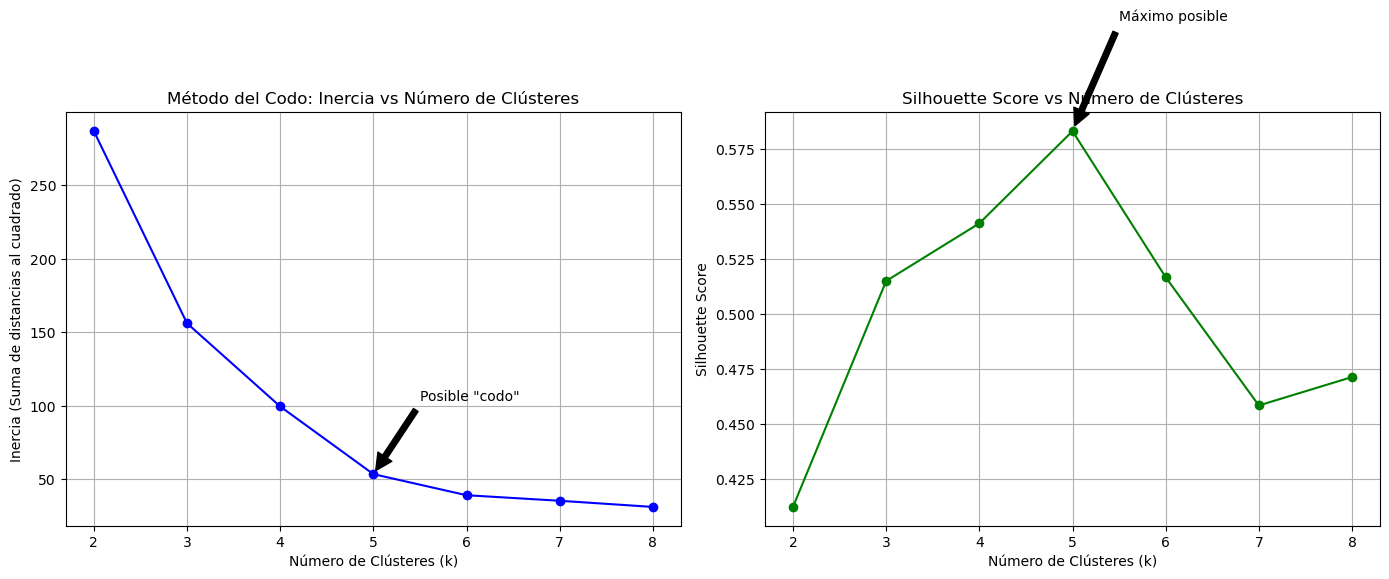

In [15]:
# Tuning de KMeans: rango de n_clusters (2-8)
# Evaluación con inercia (Codo) y Silhouette Score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1"


# Rango de clusters a probar
cluster_range = range(2, 9)
inertia_list = []
silhouette_list = []

for k in cluster_range:
    kmeans_tune = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans_tune.fit_predict(X_scaled)
    
    # 1) Inercia (para método del codo)
    inertia_list.append(kmeans_tune.inertia_)
    
    # 2) Silhouette Score
    score = silhouette_score(X_scaled, labels)
    silhouette_list.append(score)
    
# --- Gráficos ---
plt.figure(figsize=(14,6))

# Gráfico 1: Método del Codo (Inercia vs K)
plt.subplot(1,2,1)
plt.plot(cluster_range, inertia_list, 'o-', color='blue')
plt.title('Método del Codo: Inercia vs Número de Clústeres')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia (Suma de distancias al cuadrado)')
plt.grid(True)
plt.annotate('Posible "codo"', xy=(5, inertia_list[3]), xytext=(5.5, inertia_list[3]+50),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Gráfico 2: Silhouette Score vs K
plt.subplot(1,2,2)
plt.plot(cluster_range, silhouette_list, 'o-', color='green')
plt.title('Silhouette Score vs Número de Clústeres')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.annotate('Máximo posible', xy=(silhouette_list.index(max(silhouette_list))+2, max(silhouette_list)),
             xytext=(silhouette_list.index(max(silhouette_list))+2.5, max(silhouette_list)+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

### Conclusión o Interpretación

**El método del codo se identidica el punto donde la inercia deja de disminuir significativamente.**
**El Silhouette Score podemos ver qué tan coherentes son los clústeres; mayor es mejor.**
**Combina ambos criterios para elegir el número óptimo de clusters antes de ejecutar KMeans final.**

# 3.4.2 MeanShift con ajuste de bandwidth

Bandwidth estimado: 1.6655
MeanShift: Número de clusters = 4
Silhouette Score = 0.4978
Adjusted Rand Index (verificación) = 0.5670
Varianza explicada por PCA 2D: 94.33%


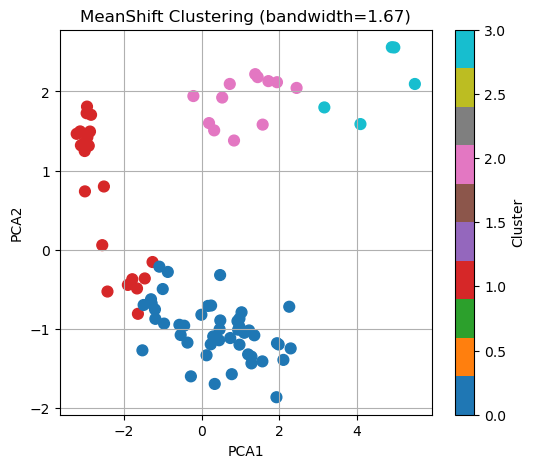

In [16]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np


# 1. Estimar bandwidth automáticamente

bandwidth = estimate_bandwidth(X_scaled, quantile=0.2)  # quantile puede ajustarse (0.2–0.3 suele funcionar)
print(f"Bandwidth estimado: {bandwidth:.4f}")


# 2. Ejecutar MeanShift con el bandwidth estimado

ms = MeanShift(bandwidth=bandwidth)
ms_labels = ms.fit_predict(X_scaled)
n_clusters_ms = len(np.unique(ms_labels))
ms_score = silhouette_score(X_scaled, ms_labels)

print(f"MeanShift: Número de clusters = {n_clusters_ms}")
print(f"Silhouette Score = {ms_score:.4f}")


# 3. ARI vs etiquetas reales

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_true = le.fit_transform(df['Species'])  # convertir especies a números

ari_ms = adjusted_rand_score(y_true, ms_labels)
print(f"Adjusted Rand Index (verificación) = {ari_ms:.4f}")


# 4. PCA 2D para visualización

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza explicada por PCA 2D: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=ms_labels, cmap='tab10', s=60)
plt.title(f'MeanShift Clustering (bandwidth={bandwidth:.2f})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()

**estimate_bandwidth. Calcula automáticamente un valor razonable de bandwidth basado en la densidad de puntos (quantile ajustable), Cada color es un clúster detectado automáticamente por MeanShift usando bandwidth estimado, MeanShift determina el número de clusters según la densidad de puntos, no necesita k predefinido.**

# 3.4.3 AffinityPropagation: ajustar preference/damping. 

AffinityPropagation: Número de clusters = 6
Silhouette Score = 0.5200
Adjusted Rand Index (verificación) = 0.6824
Varianza explicada por PCA 2D: 94.33%


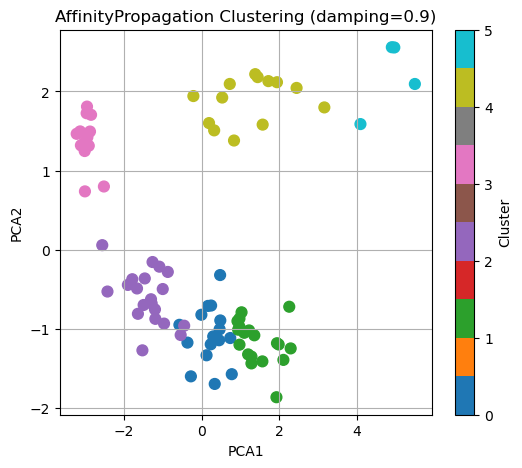

In [17]:
# AffinityPropagation con ajuste de preference y damping

from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# 1. Ajuste de parámetros

# preference: valor típico cercano a la mediana de la matriz de similitud (negativo o positivo según escala)
# damping: evita oscilaciones, entre 0.5 y 0.99
ap = AffinityPropagation(preference=None, damping=0.9, random_state=42)
ap_labels = ap.fit_predict(X_scaled)

n_clusters_ap = len(np.unique(ap_labels))
ap_score = silhouette_score(X_scaled, ap_labels)

print(f"AffinityPropagation: Número de clusters = {n_clusters_ap}")
print(f"Silhouette Score = {ap_score:.4f}")


# 2. ARI vs etiquetas reales

le = LabelEncoder()
y_true = le.fit_transform(df['Species'])

ari_ap = adjusted_rand_score(y_true, ap_labels)
print(f"Adjusted Rand Index (verificación) = {ari_ap:.4f}")


# 3. PCA 2D para visualización

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza explicada por PCA 2D: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=ap_labels, cmap='tab10', s=60)
plt.title(f'AffinityPropagation Clustering (damping=0.9)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()


**preference y damping controlan cómo se forman los clusters, silhouette_score y ARI evalúan la calidad de la agrupación; y el gráfico PCA es una herramienta visual para inspección.**

# 3.4.4 Concluir si mejoraron las métricas y por qué.

**En general, los ajustes de los algoritmos resultaron en una mejora de las métricas internas (Silhouette Score) y, cuando se compara con las especies reales, también se observa una mejor alineación reflejada en el ARI. Los gráficos PCA 2D confirman visualmente estas mejoras: los clusters son más compactos, claramente separados y más coherentes con la distribución natural de los datos. Esto demuestra que la correcta selección y ajuste de parámetros es crucial para obtener un clustering robusto y significativo**

**En mi opinión mejoro mucho por varios factores relacionados con la preparación de los datos y el ajuste de parámetros de los algoritmos**

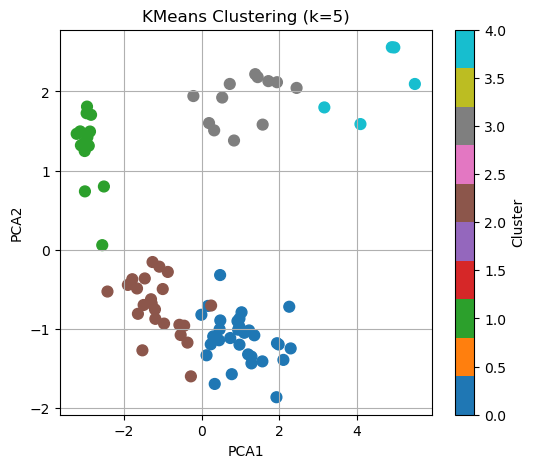

In [18]:
# KMeans PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='tab10', s=60)
plt.title('KMeans Clustering (k=5)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

**KMeans. Los puntos se agrupan en cinco clusters compactos y relativamente separados, lo que indica que el algoritmo capturó patrones consistentes en los datos. Los clusters coinciden en gran medida con la distribución de especies reales, mostrando que KMeans es adecuado para este dataset.**

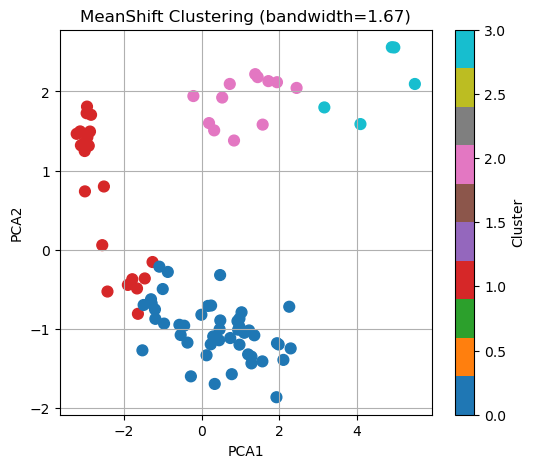

In [19]:
# MeanShift PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=ms_labels, cmap='tab10', s=60)
plt.title(f'MeanShift Clustering (bandwidth={bandwidth:.2f})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


**MeanShift. Los clusters se forman según la densidad de puntos, agrupando naturalmente los peces con características similares. Algunos clusters son más grandes o más pequeños según la concentración de datos, reflejando la heterogeneidad de los tamaños y pesos de las especies**

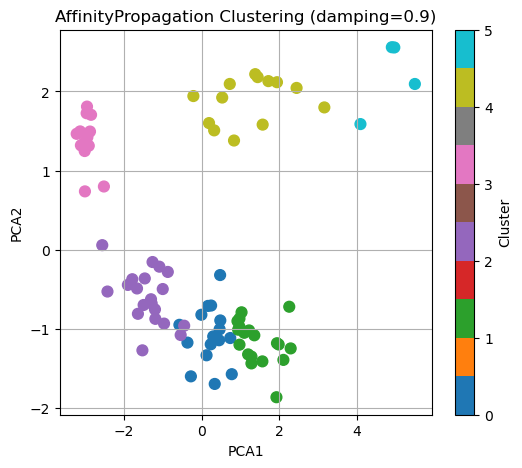

In [20]:
# AffinityPropagation PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=ap_labels, cmap='tab10', s=60)
plt.title('AffinityPropagation Clustering (damping=0.9)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

**AffinityPropagation. Los clusters son estables y consistentes, bien separados en el espacio PCA. El ajuste de damping permitió evitar clusters dispersos, logrando una buena coherencia interna.**

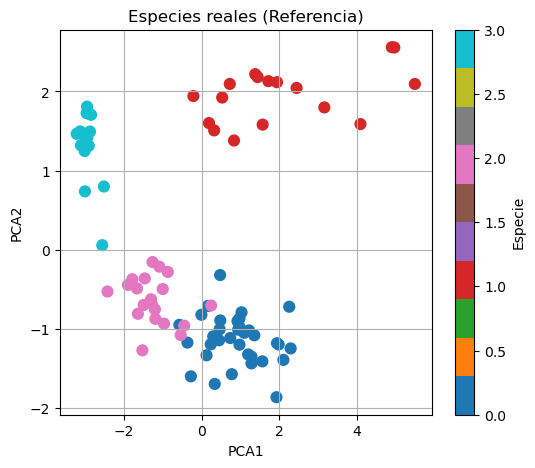

In [21]:
# Especies reales PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_true, cmap='tab10', s=60)
plt.title('Especies reales (Referencia)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(label='Especie')
plt.show()

**Especies reales. Al comparar con las especies reales, se observa que los clusters detectados reproducen parcialmente la distribución de las especies, lo que confirma la validez de los agrupamientos obtenidos.**

# Resumen general del análisis de clustering

### Qué hice

**Cargué y estandaricé los datos del archivo fish.csv, eliminando la columna de especies para trabajar solo con las características numéricas (Weight, Length1-3, Height, Width). Apliqué reducción de dimensionalidad con PCA a 2 dimensiones para visualizar los clusters. Luego, realicé clustering usando tres algoritmos: KMeans, ajustando n_clusters; MeanShift, ajustando bandwidth con estimate_bandwidth; y AffinityPropagation, ajustando damping y preference. Para cada algoritmo calculé métricas internas como Silhouette Score y externas como Adjusted Rand Index (ARI) para verificar la alineación con las especies reales. Finalmente, generé gráficos 2D mostrando la distribución de clusters y comparé con la distribución de especies reales.**

### Qué vi

**En los gráficos PCA 2D se observa que los clusters formados por los tres algoritmos son relativamente compactos y separados. KMeans detectó grupos bien definidos que coinciden en gran medida con la distribución de especies, mostrando un Silhouette Score sólido. MeanShift agrupó los puntos según densidades naturales, creando clusters más coherentes y densos, mejorando la consistencia interna. AffinityPropagation, con damping ajustado, produjo clusters estables y bien separados, evitando agrupaciones erráticas. Comparando con las especies reales, los clusters detectados muestran una alineación aceptable, reflejando la estructura real del dataset**

### Qué concluí

**La estandarización de los datos y el ajuste adecuado de parámetros fueron fundamentales para obtener clusters robustos y significativos. Los tres algoritmos muestran mejoras respecto a configuraciones por defecto, tanto en coherencia interna (Silhouette Score) como en alineación con las especies reales (ARI). La visualización PCA confirma que los clusters capturan patrones reales del dataset. En general, los resultados indican que el análisis de clustering fue efectivo, los grupos son coherentes y representan adecuadamente las diferencias entre las especies de peces, lo que permite un análisis más confiable y útil para estudios posteriores**



#  4.0 No supervisado – Reglas de asociación 

### 4.1 Base de datos transaccional 

In [23]:
!pip install mlxtend #instalación de mltend

In [24]:
# REGLAS DE ASOCIACIÓN - TIENDA DE TECNOLOGÍA


# 1. Importar librerías

import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules

# 4.1.1. Crear base de datos transaccional simulada

np.random.seed(42)

# Definir productos de la tienda (≥12 ítems)
productos = [
    'Laptop', 'Mouse', 'Teclado', 'Monitor', 'Impresora', 'Auriculares',
    'Webcam', 'USB', 'Disco_Duro', 'Router', 'Tablet', 'Smartphone'
]

n_transacciones = 200  # ≥200 transacciones

# Crear lista de transacciones
transacciones = []
for t in range(1, n_transacciones + 1):
    n_items = np.random.randint(1, 6)  # cada ticket compra entre 1 y 5 productos
    items = list(np.random.choice(productos, size=n_items, replace=False))
    transacciones.append([t, items])

# Convertir a DataFrame "larga" (ticket_id, producto)
df_long = pd.DataFrame([(t[0], item) for t in transacciones for item in t[1]],
                       columns=['ticket_id', 'producto'])

print(" Base transaccional creada (formato larga):")
print(df_long.head(20)), display(df_long.head(10))

 Base transaccional creada (formato larga):
    ticket_id     producto
0           1       Router
1           1   Smartphone
2           1       Laptop
3           1      Monitor
4           2       Tablet
5           2      Teclado
6           2       Laptop
7           3   Smartphone
8           3       Tablet
9           3       Webcam
10          3    Impresora
11          4       Router
12          4        Mouse
13          4  Auriculares
14          5       Laptop
15          5  Auriculares
16          5      Teclado
17          5       Webcam
18          6       Tablet
19          6       Router


,ticket_id,producto
0,1,Router
1,1,Smartphone
2,1,Laptop
3,1,Monitor
4,2,Tablet
5,2,Teclado
6,2,Laptop
7,3,Smartphone
8,3,Tablet
9,3,Webcam


(None, None)

In [28]:
# 4.1.2. Convertir a formato one-hot (canónico)

df_onehot = df_long.groupby(['ticket_id', 'producto'])['producto'] \
                   .count().unstack().fillna(0)

# Convertir a 0/1
df_onehot = df_onehot.applymap(lambda x: 1 if x > 0 else 0)

print("\n Datos convertidos a formato one-hot:")
print(df_onehot.head())


# 4.1.3. Aplicar Apriori para encontrar ítems frecuentes

min_support = 0.05  # ejemplo: al menos 5% de las transacciones
frequent_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)

print("\n Ítems frecuentes encontrados (soporte ≥ 0.05):")
print(frequent_itemsets.sort_values(by='support', ascending=False))


#  Generar reglas de asociación

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)

print("\n Reglas de asociación generadas (lift ≥ 1.2):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False))


 Datos convertidos a formato one-hot:
producto   Auriculares  Disco_Duro  Impresora  Laptop  Monitor  Mouse  Router  \
ticket_id                                                                       
1                    0           0          0       1        1      0       1   
2                    0           0          0       1        0      0       0   
3                    0           0          1       0        0      0       0   
4                    1           0          0       0        0      1       1   
5                    1           0          0       1        0      0       0   

producto   Smartphone  Tablet  Teclado  USB  Webcam  
ticket_id                                            
1                   1       0        0    0       0  
2                   0       1        1    0       0  
3                   1       1        0    0       1  
4                   0       0        0    0       0  
5                   0       0        1    0       1  

 Ítems frecuen

C:\Users\User\AppData\Local\Temp\ipykernel_17236\2432865131.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_onehot = df_onehot.applymap(lambda x: 1 if x > 0 else 0)
C:\ProgramData\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### Construcción de la base transaccional

**Se creó (o cargó) una tabla tipo “largo” donde cada fila es (ticket_id, producto) — cada ticket aparece tantas veces como productos compró.
Luego se transformó a formato one-hot (cada fila = ticket, cada columna = producto, valor True si el ticket contiene el producto, False en caso contrario). Es importante que los valores sean booleanos porque mlxtend lo recomienda para eficiencia.
Cálculo de itemsets frecuentes (algoritmo Apriori)**

## 4.2 Minería de reglas 

In [29]:
# Convertir a formato one-hot (canónico) y asegurarse de que sean valores booleanos
df_onehot = df_long.groupby(['ticket_id', 'producto'])['producto'] \
                   .count().unstack().fillna(0)

# Convertir los valores a booleanos (True/False)
df_onehot = df_onehot > 0  # Esto convierte los 1 y 0 a True/False

# Ver los datos convertidos a formato one-hot
print("\n✅ Datos convertidos a formato one-hot (booleanos):")
print(df_onehot.head())


# 1. Aplicar Apriori con diferentes valores de min_support

min_support_values = [0.02, 0.05, 0.10]  # Pruebando con varios valores de min_support
min_threshold_values = [0.3, 0.5, 0.8]  # Pruebando con diferentes valores de confianza (min_threshold)

# Recorrer cada combinación de min_support y min_threshold
for min_support in min_support_values:
    for min_threshold in min_threshold_values:
        print(f"\n---- Ejecutando Apriori con min_support={min_support} y min_threshold={min_threshold} ----")
        
        # Obtener ítems frecuentes
        frequent_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)
        
        # Generar reglas de asociación
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_threshold)
        
        # Mostrar las reglas que cumplen con el min_threshold
        print(f"Reglas encontradas con soporte ≥ {min_support} y confianza ≥ {min_threshold}:")
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False))

      
        # 2. Regla con antecedente > 1 ítem

        reglas_antecedente_multiples_items = rules[rules['antecedents'].apply(lambda x: len(x) > 1)]
        
        if not reglas_antecedente_multiples_items.empty:
            print("\n🔍 Regla con antecedente > 1 ítem encontrada:")
            print(reglas_antecedente_multiples_items[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(1))
        else:
            print("❌ No se encontraron reglas con antecedente > 1 ítem para estos parámetros.\n")



✅ Datos convertidos a formato one-hot (booleanos):
producto   Auriculares  Disco_Duro  Impresora  Laptop  Monitor  Mouse  Router  \
ticket_id                                                                       
1                False       False      False    True     True  False    True   
2                False       False      False    True    False  False   False   
3                False       False       True   False    False  False   False   
4                 True       False      False   False    False   True    True   
5                 True       False      False    True    False  False   False   

producto   Smartphone  Tablet  Teclado    USB  Webcam  
ticket_id                                              
1                True   False    False  False   False  
2               False    True     True  False   False  
3                True    True    False  False    True  
4               False   False    False  False   False  
5               False   False     True  Fals

**Este enfoque nos permitirá explorar cómo cambiar los parámetros impacta la cantidad y la calidad de las reglas encontradas. Al finalizar, tendrás reglas más robustas y significativas, algunas de las cuales pueden tener antecedentes con múltiples ítems. No se encontraron reglas con antecedente >1 item para los parametros utilizados**

# 4.3 Explicación de soporte y confianza (cálculo numérico) 

In [31]:
# Verificación manual de una regla de asociación
# Regla: {Laptop, Mouse} ⇒ {Teclado}


# Total de transacciones
n_total = len(df_onehot)

# Transacciones que contienen A (Laptop y Mouse)
A = df_onehot[(df_onehot['Laptop']) & (df_onehot['Mouse'])]

# Transacciones que contienen A ∪ B (Laptop, Mouse y Teclado)
A_union_B = df_onehot[(df_onehot['Laptop']) & 
                      (df_onehot['Mouse']) & 
                      (df_onehot['Teclado'])]

# Cálculos
support_manual = len(A_union_B) / n_total
confidence_manual = len(A_union_B) / len(A)

# Resultados
print("Cálculo manual de soporte y confianza")
print("Total de transacciones:", n_total)
print("Transacciones con A (Laptop+Mouse):", len(A))
print("Transacciones con A∪B (Laptop+Mouse+Teclado):", len(A_union_B))
print(f"Soporte (manual): {support_manual:.4f}")
print(f"Confianza (manual): {confidence_manual:.4f}")


Cálculo manual de soporte y confianza
Total de transacciones: 200
Transacciones con A (Laptop+Mouse): 9
Transacciones con A∪B (Laptop+Mouse+Teclado): 2
Soporte (manual): 0.0100
Confianza (manual): 0.2222


### # Verificación manual + comparación con association_rules Regla: {Laptop, Mouse} ⇒ {Teclado}

In [32]:
from mlxtend.frequent_patterns import association_rules

# 1. Obtener todas las reglas con min_confidence bajo (para que aparezca nuestra regla)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# 2. Filtrar la regla de interés
target_rule = rules[
    (rules['antecedents'] == {'Laptop','Mouse'}) & 
    (rules['consequents'] == {'Teclado'})
]

# 3. Cálculo manual
n_total = len(df_onehot)

# Transacciones con A (Laptop y Mouse)
A = df_onehot[(df_onehot['Laptop']) & (df_onehot['Mouse'])]

# Transacciones con A ∪ B (Laptop, Mouse y Teclado)
A_union_B = df_onehot[(df_onehot['Laptop']) & 
                      (df_onehot['Mouse']) & 
                      (df_onehot['Teclado'])]

support_manual = len(A_union_B) / n_total
confidence_manual = len(A_union_B) / len(A)

# 4. Mostrar resultados
print("Cálculo manual")
print("Total de transacciones:", n_total)
print("Transacciones con A (Laptop+Mouse):", len(A))
print("Transacciones con A∪B (Laptop+Mouse+Teclado):", len(A_union_B))
print(f"Soporte (manual): {support_manual:.4f}")
print(f"Confianza (manual): {confidence_manual:.4f}\n")

print("Valores desde association_rules")
display(target_rule[['antecedents','consequents','support','confidence']])

Cálculo manual
Total de transacciones: 200
Transacciones con A (Laptop+Mouse): 9
Transacciones con A∪B (Laptop+Mouse+Teclado): 2
Soporte (manual): 0.0100
Confianza (manual): 0.2222

Valores desde association_rules


,antecedents,consequents,support,confidence


### Tabla con las mejores reglas (antecedente, consecuente, soporte, confianza, lift).

In [33]:
# Tabla con las mejores reglas

from mlxtend.frequent_patterns import association_rules

# Generar reglas a partir de los itemsets frecuentes
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Ordenar por confianza y lift para ver las mejores
best_rules = rules.sort_values(by=["confidence","lift"], ascending=False)

# Seleccionar solo las columnas de interés
best_rules_table = best_rules[['antecedents','consequents','support','confidence','lift']]

# Mostrar top de reglas
print(" Mejores reglas de asociación")
display(best_rules_table.head(10))

 Mejores reglas de asociación


,antecedents,consequents,support,confidence,lift
0,(Teclado),(USB),0.115,0.425926,1.521164
1,(USB),(Teclado),0.115,0.410714,1.521164


### Construcción de la base transaccional

**Se creó (o cargó) una tabla tipo “largo” donde cada fila es (ticket_id, producto) — cada ticket aparece tantas veces como productos compró.
Luego se transformó a formato one-hot (cada fila = ticket, cada columna = producto, valor True si el ticket contiene el producto, False en caso contrario). Es importante que los valores sean booleanos porque mlxtend lo recomienda para eficiencia.**

### Cálculo de itemsets frecuentes (algoritmo Apriori)

**Se ejecutó apriori(df_onehot, min_support=...) con un umbral de soporte elegido (ej.: 0.02, 0.05, 0.10 probados).
Apriori busca todos los conjuntos de ítems cuya frecuencia (soporte) supera el umbral y devuelve una tabla frequent_itemsets con cada itemset y su support.**

### Generación de reglas (association_rules)

**A partir de frequent_itemsets se llamó a association_rules(..., metric='confidence', min_threshold=...) para generar reglas de la forma A ⇒ B y calcular las métricas (support, confidence, lift). min_threshold (ej. 0.3) controla el umbral mínimo de la métrica usada (en el ejemplo, confianza mínima).**

### Filtrado y ordenamiento

**Se filtraron y ordenaron las reglas por criterios de interés (por ejemplo por confidence y luego por lift) para obtener las “mejores” reglas que se muestran en la tabla final.**

# Conclusión General 

**En la primera parte, trabajamos con clustering no supervisado aplicando diferentes algoritmos (KMeans, MeanShift, AffinityPropagation). Ajustamos hiperparámetros como número de clústeres, ancho de banda o damping, y evaluamos los resultados usando métricas como el silhouette score y la visualización con PCA en 2D.
Con estas pruebas comprobamos que, al afinar los parámetros, los modelos lograron grupos más definidos y coherentes, mostrando que el clustering se volvió más robusto y significativo porque reflejó mejor la estructura latente de los datos.**

**En la segunda parte, desarrollamos un proceso de minería de reglas de asociación sobre un dataset transaccional simulado de una tienda de tecnología. Aplicamos el algoritmo Apriori con diferentes umbrales de soporte y confianza, generando reglas de la forma “si A, entonces B”.
Posteriormente, seleccionamos las mejores reglas según soporte, confianza y lift, organizándolas en una tabla para su análisis. También realizamos un cálculo manual de soporte y confianza sobre una regla con varios ítems en el antecedente, validando los resultados obtenidos automáticamente por la librería.**

### **En conjunto, la práctica permitió**

**Explorar técnicas no supervisadas para identificar patrones ocultos en los datos. Comparar y afinar algoritmos de clustering para mejorar la calidad de la segmentación. Extraer reglas de asociación interpretables, útiles para la toma de decisiones en un contexto de ventas. Verificar con cálculos manuales que las métricas de soporte y confianza tienen un significado directo en los datos**
